<a href="https://colab.research.google.com/github/vibha-ctrl/FlashAttentionFromScratch/blob/main/FlashAttentionFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformers rely heavily on scaled dot-product attention, but the standard implementation is memory-inefficient: it constructs the full N×N attention matrix and performs huge, repeated reads/writes between GPU HBM (global memory) and the compute cores.

Modern GPUs are memory-bandwidth bound, not compute-bound, so the bottleneck is moving data, not doing math. This becomes especially expensive because GPUs only have a few megabytes of on-chip SRAM (registers, shared memory, and cache), which is far too small to hold the full attention matrix or all of Q, K, and V at once. As a result, naive attention repeatedly streams large blocks of data from slow HBM, making it both memory-hungry and slow.

FlashAttention solves this by using a tiling algorithm that keeps small blocks of Q, K, and V in fast on-chip SRAM and never materializes the full N×N attention matrix. By minimizing HBM traffic and maximizing on-chip reuse, it dramatically reduces memory usage and significantly improves speed.

In this notebook, we’ll implement both naive attention and FlashAttention to compare their performance. We’ll use randomly initialized tensors for Q, K, and V, since the goal is to understand algorithmic differences and memory behavior not semantic output. If your local machine doesn’t have a GPU like mine, you can run everything on an NVIDIA A100 GPU in Google Colab.


1) Implement Naive Attention (Baseline)

    Naive attention computes the full N×N attention matrix in memory. For each query token, we calculate similarity scores with all key tokens, apply softmax, then compute a weighted sum of values. This standard implementation materializes the entire [seq_len × seq_len] attention matrix, which becomes memory-intensive for long sequences.

    This outlines the process with naive attention:

    1. Read Q, K from HBM          (slow)

    2. Compute Q @ K.T             (fast - on GPU cores)
    3. Write scores to HBM         (slow)
    4. Read scores from HBM        (slow)
    5. Compute softmax             (fast)
    6. Write attn_weights to HBM   (slow)
    7. Read attn_weights, V from HBM (slow)
    8. Compute attn @ V            (fast)
    9. Write output to HBM         (slow)


      

In [6]:
def naive_attention(Q, K, V):
    d_head = Q.shape[-1]
    scores = Q @ K.transpose(-2, -1) / (d_head ** 0.5)
    attn_weights = torch.softmax(scores, dim=-1)
    output = attn_weights @ V
    return output

2) Implement FlashAttention in Triton

    FlashAttention uses a tiling algorithm to compute attention in blocks that fit in fast SRAM. Instead of materializing the full attention matrix, we process small tiles of Q, K, V at a time, computing partial results and accumulating them using online softmax. This dramatically reduces memory usage and speeds up computation by minimizing slow HBM memory transfers.

    This outlines the process for FlashAttention:

    1. Read Q block from HBM to SRAM                    (slow, but small block)
    
    2. Loop over K/V blocks:

        a. Read K block, V block from HBM to SRAM        (slow, but small blocks)

        b. Compute Q @ K.T in SRAM                       (fast - on GPU cores)
        
        c. Compute softmax numerators (p) in SRAM        (fast)

        d. Update running statistics (m_i, l_i) in SRAM  (fast)

        e. Compute p @ V in SRAM                         (fast)

        f. Update accumulator (acc) in SRAM              (fast)

        g. Discard K, V, p blocks                        (no HBM write!)
    3. Normalize: acc / l_i in SRAM                     (fast)
    4. Write output block to HBM                        (slow, but only once)

    Here's a walkthrough of the process with example values:

    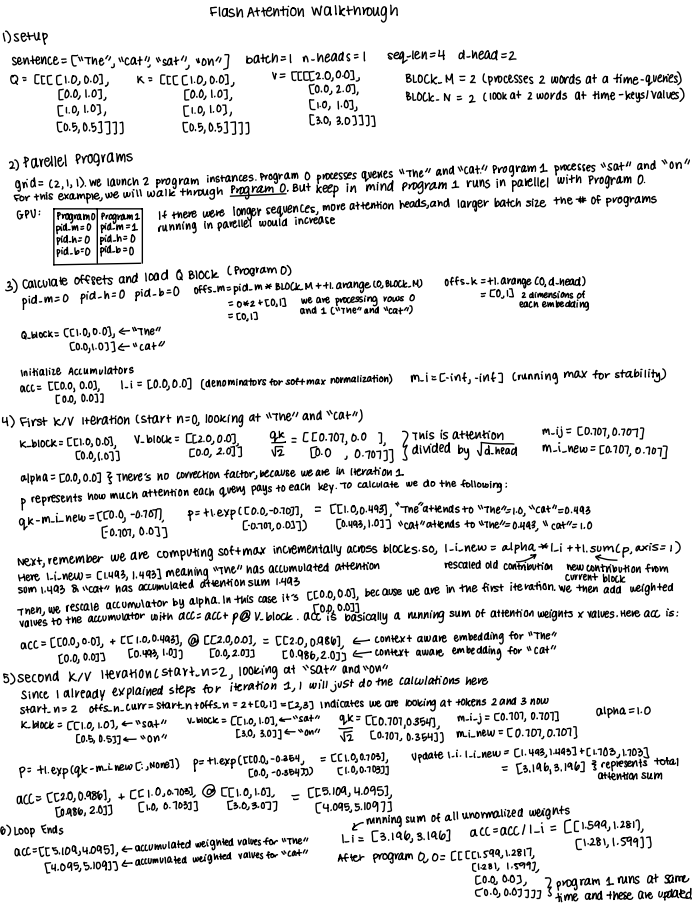



In [11]:
import triton
import triton.language as tl
import torch

@triton.jit
def flash_attention_kernel(
    Q, K, V, O,
    stride_qb, stride_qh, stride_qm, stride_qk,
    stride_kb, stride_kh, stride_kn, stride_kk,
    stride_vb, stride_vh, stride_vn, stride_vk,
    stride_ob, stride_oh, stride_om, stride_ok,
    N, d_head: tl.constexpr,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr,
):
    pid_m = tl.program_id(0)
    pid_h = tl.program_id(1)
    pid_b = tl.program_id(2)

    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_k = tl.arange(0, d_head)

    q_ptrs = (
        Q
        + pid_b * stride_qb
        + pid_h * stride_qh
        + offs_m[:, None] * stride_qm
        + offs_k[None, :] * stride_qk
    )
    Q_block = tl.load(q_ptrs, mask=offs_m[:, None] < N, other=0.0)

    acc = tl.zeros([BLOCK_M, d_head], dtype=tl.float32)
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    m_i = tl.full([BLOCK_M], -float("inf"), dtype=tl.float32)

    for start_n in range(0, N, BLOCK_N):
        offs_n_curr = start_n + offs_n

        k_ptrs = (
            K
            + pid_b * stride_kb
            + pid_h * stride_kh
            + offs_n_curr[:, None] * stride_kn
            + offs_k[None, :] * stride_kk
        )
        K_block = tl.load(k_ptrs, mask=offs_n_curr[:, None] < N, other=0.0)

        v_ptrs = (
            V
            + pid_b * stride_vb
            + pid_h * stride_vh
            + offs_n_curr[:, None] * stride_vn
            + offs_k[None, :] * stride_vk
        )
        V_block = tl.load(v_ptrs, mask=offs_n_curr[:, None] < N, other=0.0)

        qk = tl.dot(Q_block, tl.trans(K_block))
        qk = qk / tl.sqrt(float(d_head))

        m_ij = tl.max(qk, axis=1)
        m_i_new = tl.maximum(m_i, m_ij)

        alpha = tl.exp(m_i - m_i_new)
        p = tl.exp(qk - m_i_new[:, None])

        l_i_new = alpha * l_i + tl.sum(p, axis=1)

        acc = acc * alpha[:, None]
        acc = acc + tl.dot(p, V_block)

        l_i = l_i_new
        m_i = m_i_new

    acc = acc / l_i[:, None]

    o_ptrs = (
        O
        + pid_b * stride_ob
        + pid_h * stride_oh
        + offs_m[:, None] * stride_om
        + offs_k[None, :] * stride_ok
    )
    tl.store(o_ptrs, acc, mask=offs_m[:, None] < N)


def flash_attention(Q, K, V):
    batch, n_heads, seq_len, d_head = Q.shape
    O = torch.empty_like(Q)

    BLOCK_M = 64
    BLOCK_N = 64

    grid = (triton.cdiv(seq_len, BLOCK_M), n_heads, batch)

    flash_attention_kernel[grid](
        Q, K, V, O,
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        V.stride(0), V.stride(1), V.stride(2), V.stride(3),
        O.stride(0), O.stride(1), O.stride(2), O.stride(3),
        seq_len, d_head,
        BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N,
    )
    return O

3) Benchmark

    We measure the execution time and memory usage of Naive Attention v.s. FlashAttention. We find that FlashAttention uses less time and memory compared to naive attention.

Benchmarking...
seq_len=512: Naive 0.2ms/0.040GB, Flash 0.0ms/0.023GB
seq_len=1024: Naive 0.5ms/0.095GB, Flash 0.1ms/0.027GB
seq_len=2048: Naive 1.7ms/0.304GB, Flash 0.3ms/0.036GB
seq_len=4096: Naive 5.1ms/1.126GB, Flash 0.7ms/0.053GB


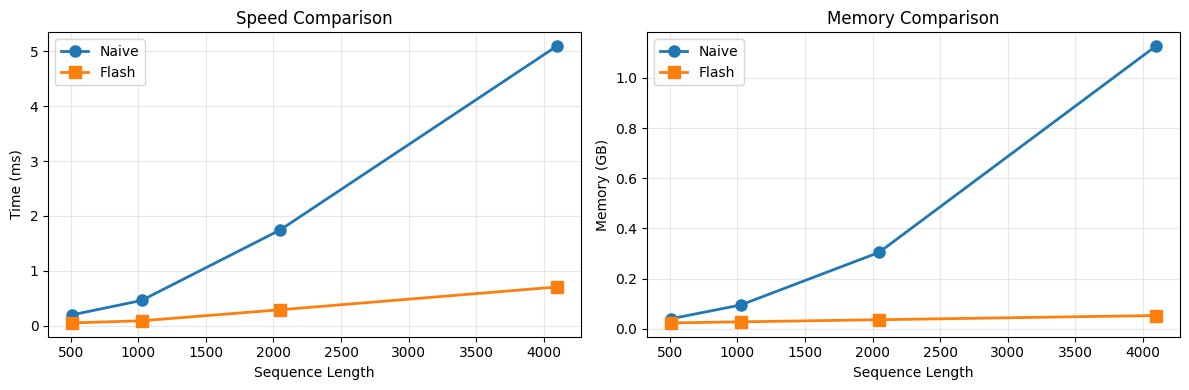

In [12]:
import matplotlib.pyplot as plt
import torch
import time

# Simple benchmark function
def benchmark(fn, *args, num_runs=50):
    # Warmup
    for _ in range(5):
        _ = fn(*args)

    torch.cuda.synchronize()
    start = time.time()

    for _ in range(num_runs):
        _ = fn(*args)

    torch.cuda.synchronize()
    end = time.time()

    return (end - start) / num_runs * 1000  # Return milliseconds

# Test different sequence lengths
seq_lengths = [512, 1024, 2048, 4096]
naive_times = []
flash_times = []
naive_mems = []
flash_mems = []

print("Benchmarking...")
for seq_len in seq_lengths:
    Q = torch.randn(1, 8, seq_len, 64, device='cuda')
    K = torch.randn(1, 8, seq_len, 64, device='cuda')
    V = torch.randn(1, 8, seq_len, 64, device='cuda')

    # Naive
    torch.cuda.reset_peak_memory_stats()
    t_naive = benchmark(naive_attention, Q, K, V)
    m_naive = torch.cuda.max_memory_allocated() / 1e9

    # Flash
    torch.cuda.reset_peak_memory_stats()
    t_flash = benchmark(flash_attention, Q, K, V)
    m_flash = torch.cuda.max_memory_allocated() / 1e9

    naive_times.append(t_naive)
    flash_times.append(t_flash)
    naive_mems.append(m_naive)
    flash_mems.append(m_flash)

    print(f"seq_len={seq_len}: Naive {t_naive:.1f}ms/{m_naive:.3f}GB, Flash {t_flash:.1f}ms/{m_flash:.3f}GB")

# Simple plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Time
ax1.plot(seq_lengths, naive_times, 'o-', label='Naive', linewidth=2, markersize=8)
ax1.plot(seq_lengths, flash_times, 's-', label='Flash', linewidth=2, markersize=8)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Speed Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Memory
ax2.plot(seq_lengths, naive_mems, 'o-', label='Naive', linewidth=2, markersize=8)
ax2.plot(seq_lengths, flash_mems, 's-', label='Flash', linewidth=2, markersize=8)
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Memory (GB)')
ax2.set_title('Memory Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()